In [1]:
import sys
from pathlib import Path
import torch

ROOT_PATH=Path("..").resolve().absolute()
DEVICE=torch.device("cuda")#torch.device("cpu")
sys.path.append(str(ROOT_PATH))

%load_ext autoreload
%autoreload 2

In [2]:
import main.module_base
from audio_diffusion_pytorch import LogNormalDistribution
import torch
from misc import load_model

model_1 = load_model("../logs/ckpts/2022-11-28-01-14-30/epoch=19999-valid_loss=0.036.ckpt", DEVICE)
model_2 = load_model("../logs/ckpts/2022-11-22-18-14-22/epoch=10571-valid_loss=0.200.ckpt", DEVICE)

/home/giorgio/miniconda3/envs/audio-diffusion-trainer/lib/python3.9/site-packages/matplotlib/axes/_axes.py:7690: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


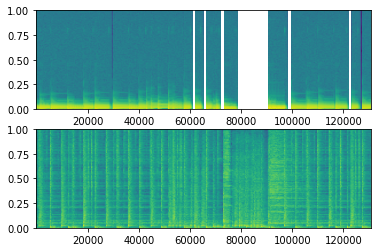

In [3]:
import torchaudio
from IPython.display import Audio
from misc import load_audio
import math
from audio_data_pytorch.transforms import Loudness
import matplotlib.pyplot as plt

sampling_rate = 22050
length_samples = 262144 #2**math.ceil(math.log2(length * sampling_rate))

start, end = 170 * sampling_rate, 170 * sampling_rate + length_samples
s1 = load_audio('/data/MusDB/data/test_MusDB_reduced/Al James - Schoolboy Facination/bass.wav', sampling_rate, start, end)
s2 = load_audio('/data/MusDB/data/test_MusDB_reduced/Al James - Schoolboy Facination/drums.wav', sampling_rate, start, end)
#s1 = load_audio('/data/MusDB/data/test_MusDB_reduced/Arise - Run Run Run/bass.wav', sampling_rate, start, end)
#s2 = load_audio('/data/MusDB/data/test_MusDB_reduced/Arise - Run Run Run/drums.wav', sampling_rate, start, end)
#s1 = load_audio('/data/MusDB/data/test_MusDB_reduced/Ben Carrigan - We\'ll Talk About It All Tonight/bass.wav', sampling_rate, start, end)
#s2 = load_audio('/data/MusDB/data/test_MusDB_reduced/Ben Carrigan - We\'ll Talk About It All Tonight/drums.wav', sampling_rate, start, end)

# convert to mono
s1, s2 = s1.sum(dim=1, keepdims=True), s2.sum(dim=1, keepdims=True)
m = s1 + s2

def plot_waves(s1, s2):    
    fig = plt.figure()
    axes = fig.add_subplot(2,1,1)
    spec, _, _, img = plt.specgram(s1.reshape(-1), NFFT=1024,)

    axes = fig.add_subplot(2,1,2)
    spec, _, _, img = plt.specgram(s2.reshape(-1), NFFT=1024,)

    #plt.legend(["piano", "bass"])
    plt.show()
    
    display(Audio(s1.reshape(1,-1), rate = sampling_rate))
    display(Audio(s2.reshape(1,-1), rate = sampling_rate))
    display(Audio((s1+s2).reshape(1,-1), rate = sampling_rate))
    
plot_waves(s1, s2)

In [4]:
import torchmetrics.functional.audio as tma
from main.evaluate_separation import museval_sdr as msdr

def si_snr(preds, targets):
    return tma.scale_invariant_signal_distortion_ratio(preds.cpu(), targets.cpu()).item()

def sdr(preds, targets):
    preds = preds.cpu()
    targets = targets.cpu()

    signal = torch.norm(targets) ** 2
    e_error = torch.norm(preds - targets) ** 2
    return 10 * torch.log10( signal/e_error )


def museval_sdr(y1,y2,s1,s2):
    preds = torch.stack([y1,y2],dim=1)
    target = torch.stack([s1,s2], dim=1)
    museval_sdr(preds, target, sampling_rate)
    
def plot_spectrogram(s1, s2):    
    fig = plt.figure()
    axes = fig.add_subplot(2,1,1)
    spec, _, _, img = plt.specgram(s1.reshape(-1), NFFT=1024,)

    axes = fig.add_subplot(2,1,2)
    spec, _, _, img = plt.specgram(s2.reshape(-1), NFFT=1024,)

    #plt.legend(["piano", "bass"])
    plt.show()

    
def plot_separation(y1, y2, m):
    print("separation 1")
    display(Audio(y1.detach().cpu().view(1,-1), rate = sampling_rate))
    
    print("separation 2")
    display(Audio(y2.detach().cpu().view(1,-1), rate = sampling_rate))
    
    print("gt 1")
    display(Audio(s1.detach().cpu().view(1,-1), rate = sampling_rate))
    
    print("gt 2")
    display(Audio(s2.detach().cpu().view(1,-1), rate = sampling_rate))
    
    print("mixture of separations")
    display(Audio((y1+y2).detach().cpu().view(1,-1), rate = sampling_rate))
    
    print("error of separation 1")
    display(Audio((s1-y1.cpu()).detach().cpu().view(1,-1), rate = sampling_rate))
    
    print("error of separation 2")
    display(Audio((s2-y2.cpu()).detach().cpu().view(1,-1), rate = sampling_rate))
    
    print("mixture")
    display(Audio((m).detach().cpu().view(1,-1), rate = sampling_rate))

    print(f"SI-SNR (1): {si_snr(y1, s1)}")
    print(f"SI-SNR (2): {si_snr(y2, s2)}")
    print(f"SI-SNR - mistura: {si_snr(s1, m)}, {si_snr(s2, m)}")
    print(f"SI-SNRi(1): {si_snr(y1, s1) - si_snr(s1, m)}")
    print(f"SI-SNRi (2): {si_snr(y2, s2) - si_snr(s2, m)}")
    print(f"SI-SNR (mix): {si_snr(y1+y2, m)}")

    print("(1)")
    plot_spectrogram(y1.cpu(), s1.cpu())
    print("(2)")
    plot_spectrogram(y2.cpu(), s2.cpu())
    #plot_waves((s1.cpu()-y1.cpu()), (s2.cpu()-y2.cpu()))
    
def plot_error(preds, target, start=0, duration=1000, step=1):
    preds = preds.cpu()[0,0,:]
    target = target.cpu()[0,0,:]
    
    s_hat = preds
    s_target = torch.dot(s_hat, target) * target / target.norm()**2
    s_error = s_hat - s_target

    plt.figure(figsize=(20,10))
    plt.subplot(1, 2, 1)
    plt.plot(s_target[start:start+duration:step])
    plt.plot(s_hat[start:start+duration:step], "g--")
    plt.legend(["target", "preds"])
    
    plt.subplot(1, 2, 2)
    plt.plot(s_hat[start:start+duration:step], "g--")
    #plt.plot(s_error.abs()[start:start+duration:step], "y")
    e = s_error.abs()[start:start+duration:step]
    plt.fill_between(range(len(e)), e, -e, alpha=0.25, color="y")
    plt.legend(["preds","error"])


    print(10*torch.log10(s_target.norm()**2/s_error.norm()**2))
    #print(si_snr(m-y2, s1))
    print(s_error.norm()**2)

separation 1


separation 2


gt 1


gt 2


mixture of separations


error of separation 1


error of separation 2


mixture


SI-SNR (1): 9.273635864257812
SI-SNR (2): 5.830282211303711
SI-SNR - mistura: 2.78617262840271, -2.31524920463562
SI-SNRi(1): 6.4874632358551025
SI-SNRi (2): 8.145531415939331
SI-SNR (mix): 12.434751510620117
(1)


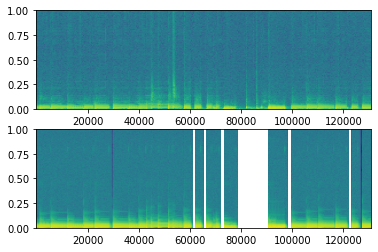

(2)


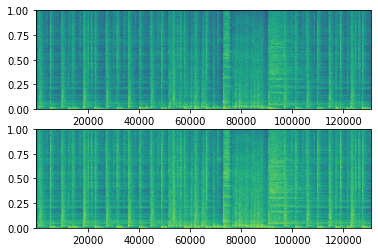

tensor(9.1353) tensor(6.1348)


In [35]:
from main.separation import (
    KarrasSeparator, 
    RungeKuttaExtractor, 
    EulerExtractor, 
    AEulerSeparator, 
    AEulerSeparatorSymmetric, 
    ADPM2Extractor, 
    ADPM2Separator, 
    enforce_mixture_consistency, 
    EulerSeparator
)

from main.scratch_samplers import HeunExtractor, CrawsonHeunExtractor, CrawsonEulerExtractor
from audio_diffusion_pytorch.diffusion import KarrasSchedule
import numpy as np
from misc import display_audio

@torch.no_grad()
def separate(
    model1,
    model2,
    mixture, 
    device: torch.device = torch.device("cuda"), 
    num_steps:int = 100,
):
    
    batch, in_channels = 1, 1
    samples = mixture.shape[-1]

    m = mixture.to(device)
    models = [model1.model, model2.model]
    
    for model in models:
        model.to(device)
        
    sigma_sched = KarrasSchedule(sigma_min=0.0001, sigma_max=20.0, rho=7.0)
    diffusion_separator = CrawsonEulerExtractor(mixture=m)

    sigma = sigma_sched(num_steps, device)
    fns = [model.diffusion.denoise_fn for model in models]
    noises = [torch.randn_like(m).to(device), torch.randn_like(m).to(device)]
    return diffusion_separator.forward(noises=noises, fns=fns, sigmas=sigma, num_steps=num_steps, s_churn=40.)

y1, y2 = separate(model_1, model_2, m, num_steps=100)
#y1, y2 = y1.cpu(), y2.cpu()
#y1, y2 = m.cuda() - y2, m.cuda() - y1

#y1, y2 = enforce_mixture_consistency(m.to(DEVICE), torch.stack([y1, y2], dim=1))

plot_separation(y1,y2,m)
print(sdr(y1,s1), sdr(y2,s2))

In [61]:
@torch.no_grad()
def compute_norm(
    noise: Tensor, 
    denoise_fn,
    sampler,
    sigmas: torch.Tensor, 
    num_steps: int = 10,
) -> List[Tensor]:

    device = noise.device
    assert exists(num_steps), "Parameter `num_steps` must be provided"        
    
    # Separation procedure
    x = sigmas[0] * noise

    # Denoise to sample
    grad_norms = []
    for step in range(num_steps - 1):
        grad_log_p = (x - denoise_fn(x, sigma=sigmas[step])) / sigmas[step]**2
        grad_norms += [grad_log_p.norm().cpu()]
        x = sampler.step(x, fn=denoise_fn, sigma=sigmas[step], sigma_next=sigmas[step + 1])
                
    return x.clamp(-1.0, 1.0), torch.stack(grad_norms)


@torch.no_grad()
def compute_score_norm(model, device: torch.device = torch.device("cuda"), num_steps:int = 100):
    
    model.to(device)
    noise = torch.randn((num_samples, 1, length_samples)).to(device)
    schedule = KarrasSchedule(sigma_min=1e-4, sigma_max=1.0, rho=9.0)
    sigmas = schedule(num_steps, device)
    x, norms = compute_norm(
        noise = noise,
        denoise_fn = model.model.diffusion.denoise_fn,
        sampler = ADPM2Sampler(rho=1.0),
        sigmas = sigmas,
        num_steps = num_steps
    )
    return norms.cpu(), sigmas[:-2].cpu()


grads, sigmas = compute_score_norm(model_2)
#print(grads, sigmas)

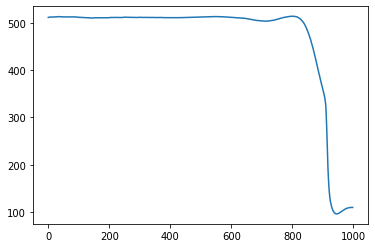

In [60]:
import matplotlib.pyplot as plt
plt.plot(grads*sigmas)

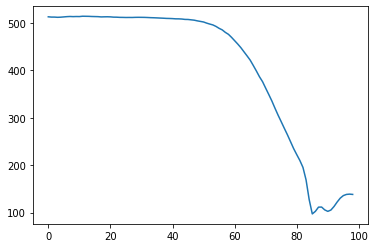

In [62]:
plt.plot(grads*sigmas)

In [ ]:
torchaudio.save("s1.wav", s1.reshape(1,-1).cpu(), 22050)
torchaudio.save("s2.wav", s2.reshape(1,-1).cpu(), 22050)
torchaudio.save("m.wav", m.reshape(1,-1).cpu(), 22050)

In [ ]:
from audio_diffusion_pytorch.diffusion import AEulerSampler, ADPM2Sampler, Diffusion, KarrasSchedule, Sampler, Schedule

with torch.no_grad():
     samples = model_1.model.sample(
         noise=torch.randn((num_samples, 2, length_samples), device=DEVICE),
         num_steps=100,
         sigma_schedule=KarrasSchedule(sigma_min=1e-4, sigma_max=3.0, rho=7.0),
         sampler=ADPM2Sampler(),
     )

# Log audio samples
for i, sample in enumerate(samples):
     display(Audio(sample.cpu(), rate = sampling_rate))

In [ ]:
k = KarrasSchedule(sigma_min=1e-4, sigma_max=3.0, rho=9.0)
sigmas_rev = k(num_steps=99, device="cpu")

#step_size = torch.tensor([3e-1]*100)

import matplotlib.pyplot as plt
#plt.plot(sigmas)
plt.plot(compute_likelihood_steps(sigmas_rev, gamma=0.0128))
#plt.plot(step_size)

In [ ]:
from audio_diffusion_pytorch.diffusion import KarrasSchedule
import matplotlib.pyplot as plt
import numpy as np

def plot_wave(s1):    
    fig = plt.figure()
    axes = fig.add_subplot(2,1,1)
    spec, _, _, img = plt.specgram(s1.reshape(-1), NFFT=1024,)
    plt.show()
    
    display(Audio(s1.reshape(1,-1), rate = sampling_rate))

k = KarrasSchedule(sigma_min=1e-4, sigma_max=3.0, rho=9.0)
sigmas = k(num_steps=10, device="cpu")

plt.plot(sigmas)
noise = torch.randn_like(s1).cpu()

for sigma in sigmas:
    print(f"({sigma}) SI-SNR : {si_snr(sigma*noise + s1, s1)}")
    #plot_wave(sigma*noise + s1)
    print("-----------------------\n")

In [ ]:
x=np.arange(100)/1000
y=10*np.log10(np.linalg.norm(s1)**2 / (s1.numel()*x**2))
#plt.plot(x,y)
import plotly.express as px
px.line(y)

In [ ]:
import math
from IPython.display import Audio
from audio_diffusion_pytorch.diffusion import ADPM2Sampler, KarrasSchedule
sampling_rate=22050

device="cuda"
with torch.no_grad():
    
    model = model_2.model
    model.to(device)
        
    samples = model.sample(
         noise=torch.randn((1, 1, 2**math.ceil(math.log2(10 * sampling_rate))), device='cuda'),
         num_steps=100,
         sigma_schedule=KarrasSchedule(
             sigma_min=1e-4,
             sigma_max=1.0,
             rho=9.0
         ),
         sampler=ADPM2Sampler(rho=1.0),
     )

# Log audio samples
for i, sample in enumerate(samples):
    display(Audio(sample.cpu(), rate = sampling_rate))